<a href="https://colab.research.google.com/github/Bilal3099/Transfer-Learning/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from sklearn import metrics

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout,Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/archive/chest_xray/'
train_ds_path = input_path + 'train'
test_ds_path = input_path + 'test'
val_ds_path = input_path + 'val'

In [ ]:
img_size = 150
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batch = train_datagen.flow_from_directory(
              train_ds_path,
              target_size = (img_size, img_size),
              batch_size = batch_size,
              shuffle=True,
              class_mode = 'binary'
)


val_batch = val_datagen.flow_from_directory(
            val_ds_path,
            target_size = (img_size, img_size),
            batch_size = batch_size,
            shuffle=False,
            class_mode = 'binary'
)

test_batch = test_datagen.flow_from_directory(
             test_ds_path,
             target_size = (img_size, img_size),
             batch_size = batch_size,
             shuffle=False,
             class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
imgs, label = next(train_batch)

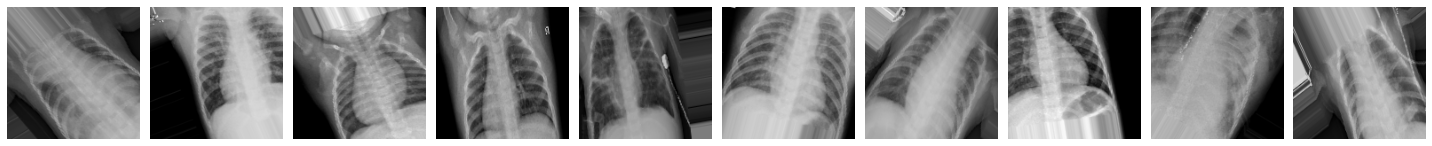

[1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1.]


In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip (images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()  

plotImages(imgs)
print(label)

In [ ]:
def build_model(backbone, learning_rate=1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['acc']
    )
  return model

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model = build_model(resnet, learning_rate=1e-4)
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                         

In [ ]:
history = model.fit(
    train_batch,
    steps_per_epoch=163,
    epochs=20,
    validation_data=test_batch,
    validation_steps=20
)

Epoch 1/20
163/163 [==============================] - 1631s 10s/step - loss: 0.2619 - acc: 0.9107 - val_loss: 4.1713 - val_acc: 0.3750
Epoch 2/20
163/163 [==============================] - 97s 596ms/step - loss: 0.1540 - acc: 0.9513 - val_loss: 8.6457 - val_acc: 0.6250
Epoch 3/20
163/163 [==============================] - 99s 607ms/step - loss: 0.1332 - acc: 0.9586 - val_loss: 1.9297 - val_acc: 0.6250
Epoch 4/20
163/163 [==============================] - 97s 593ms/step - loss: 0.1216 - acc: 0.9615 - val_loss: 1.1508 - val_acc: 0.6250
Epoch 5/20
163/163 [==============================] - 97s 593ms/step - loss: 0.0908 - acc: 0.9732 - val_loss: 1.8089 - val_acc: 0.6250
Epoch 6/20
163/163 [==============================] - 98s 599ms/step - loss: 0.0970 - acc: 0.9701 - val_loss: 1.4215 - val_acc: 0.6266
Epoch 7/20
163/163 [==============================] - 96s 590ms/step - loss: 0.0818 - acc: 0.9734 - val_loss: 0.2349 - val_acc: 0.8990
Epoch 8/20
163/163 [==============================] - 9

In [ ]:
model.save('ResNet50Model.h5')

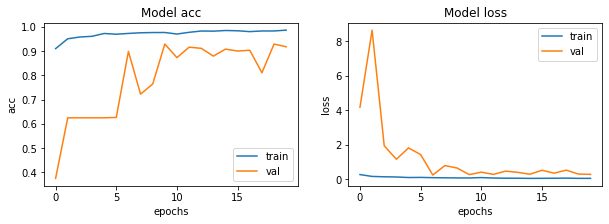

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [ ]:
pred = model.predict(val_batch)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred

array([[3.0211520e-01],
       [9.8038018e-02],
       [1.2620251e-01],
       [6.6565764e-01],
       [7.1461409e-01],
       [4.2009196e-01],
       [1.7429684e-01],
       [2.2781199e-27],
       [9.9995804e-01],
       [9.9998283e-01],
       [9.9786961e-01],
       [9.9030334e-01],
       [9.9931169e-01],
       [9.9999678e-01],
       [9.9993634e-01],
       [9.8585469e-01]], dtype=float32)

In [ ]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
y_pred

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true=val_batch.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

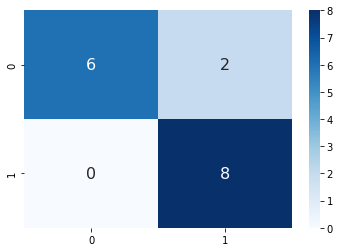

In [ ]:
import seaborn as sn
sn.heatmap(cm, annot=True,cmap="Blues", annot_kws={"size": 16})

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



ROC:  0.875


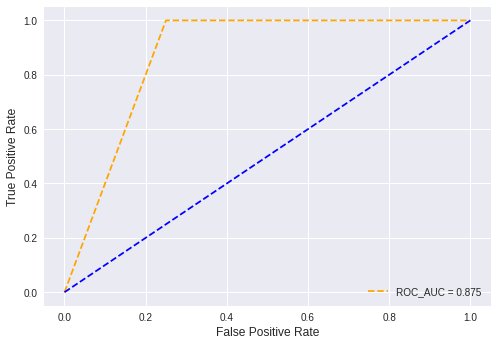

In [ ]:
roc_auc = metrics.roc_auc_score(y_true, y_pred)
print('ROC: ', roc_auc)

random_probs = [0 for i in range(len(y_true))]
p_fpr, t_fpr, thresholds = metrics.roc_curve(y_true, random_probs)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

plt.style.use('seaborn')
plt.plot(fpr, tpr, linestyle = '--', color='orange', label='ROC_AUC = %0.3f' % roc_auc)
plt.plot(p_fpr, t_fpr, linestyle = '--', color = 'blue')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc = 'lower right')

plt.show()


In [ ]:
def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'PNEUMONIA')

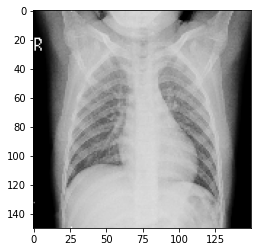

1/1 [==============================] - 2s 2s/step
Predictions:  [[0.02792965]] NORMAL


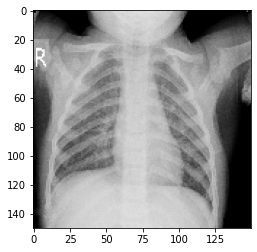

1/1 [==============================] - 0s 50ms/step
Predictions:  [[0.00044793]] NORMAL


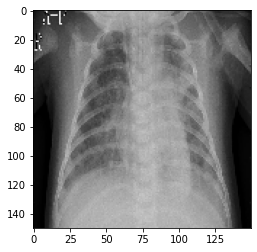

1/1 [==============================] - 0s 83ms/step
Predictions:  [[0.99999845]] PNEUMONIA


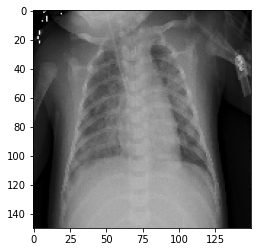

1/1 [==============================] - 0s 53ms/step
Predictions:  [[0.9999906]] PNEUMONIA


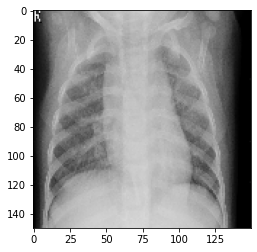

1/1 [==============================] - 0s 45ms/step
Predictions:  [[0.99729025]] PNEUMONIA


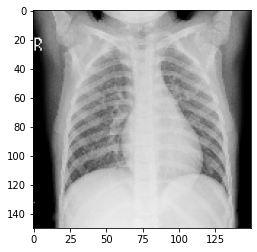

1/1 [==============================] - 0s 104ms/step
Predictions:  [[0.00420529]] NORMAL


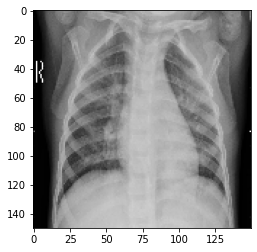

1/1 [==============================] - 0s 38ms/step
Predictions:  [[0.99695444]] PNEUMONIA


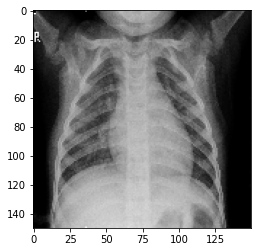

1/1 [==============================] - 0s 42ms/step
Predictions:  [[0.86329216]] PNEUMONIA


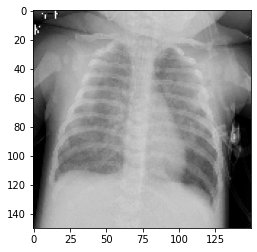

1/1 [==============================] - 0s 71ms/step
Predictions:  [[0.99997187]] PNEUMONIA


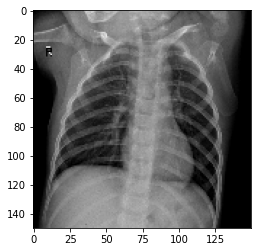

1/1 [==============================] - 0s 58ms/step
Predictions:  [[1.04053e-07]] NORMAL


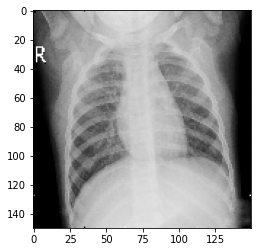

1/1 [==============================] - 0s 73ms/step
Predictions:  [[0.5675016]] PNEUMONIA


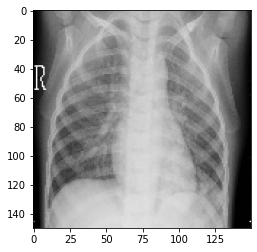

1/1 [==============================] - 0s 74ms/step
Predictions:  [[0.9996904]] PNEUMONIA


In [ ]:
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1427-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1430-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4874.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1946_bacteria_4875.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1947_bacteria_4876.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1431-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1949_bacteria_4880.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1436-0001.jpeg'))
predict_image(model,(val_ds_path + '/PNEUMONIA/person1952_bacteria_4883.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1442-0001.jpeg'))
predict_image(model,(val_ds_path + '/NORMAL/NORMAL2-IM-1438-0001.jpeg'))
predict_image(model,(val_ds_path + '//PNEUMONIA/person1950_bacteria_4881.jpeg'))

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model('ResNet50Model.h5')
new_model.summary()

In [ ]:
predict_image(new_model,(val_ds_path + '/NORMAL/NORMAL2-IM-1427-0001.jpeg'))